# **Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
from scipy import stats
from IPython.display import clear_output, display_html

In [2]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Loading Datasets**

In [3]:
train=pd.read_csv("train.csv")

In [4]:
test=pd.read_csv("test.csv")

In [5]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [8]:
train['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.  The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.  most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go take 

In [9]:
#using re library to replace /n kind words with empty space
import re
train['full_text'] = train["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
test['full_text'] = test["full_text"].replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

## **Exploratory Data Analysis**

## **Applying of word_tokenize() and Counter() Functions**

In [10]:
from nltk.tokenize import word_tokenize
from collections import Counter 

corpus = ''.join(train.full_text)
d = Counter(corpus.split())
words_counting = pd.DataFrame({'words':list(d.keys()), 'count':list(d.values())})
words_counting['word_len'] = words_counting['words'].apply(lambda x: len(x))
words_counting = words_counting.sort_values(by = 'word_len', ascending = False)

In [11]:
words_counting['words'].head(2)

10471    ride,rock-climb,roller-skating,surfing,camping...
8857     opinions,strategies,problems,situation,stateme...
Name: words, dtype: object

## **Counting the apperance of word 'Generic'**

In [12]:
print('Amount of Generic Sequences: ',words_counting[words_counting.words.str.contains('Generic')]['count'].sum())

Amount of Generic Sequences:  1769


## **kernel density estimate (KDE) plot**

* The 'x' parameter computes the length of each text sample in train dataset 
after splitting it into words. 
* The 'ec' parameter is set to "#000", which sets the color of the edges of the filled area to black. 
* The 'fill' parameter is set to True, which fills the area under the KDE curve. 
* The 'alpha' parameter is set to 1, which sets the opacity of the filled area to maximum. 
* The 'ax' parameter is set to ax, which specifies the subplot to which the KDE plot should be added.


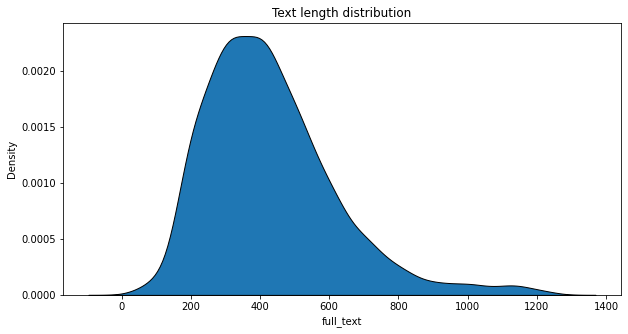

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
sns.kdeplot(x=train['full_text'].apply(lambda x: len(x.split())), data=train, ec="#000", fill=True, alpha=1, ax=ax, zorder=2)
ax.set_title("Text length distribution")
fig.show()

## **Word cloud visualization**

In [14]:
from wordcloud import WordCloud

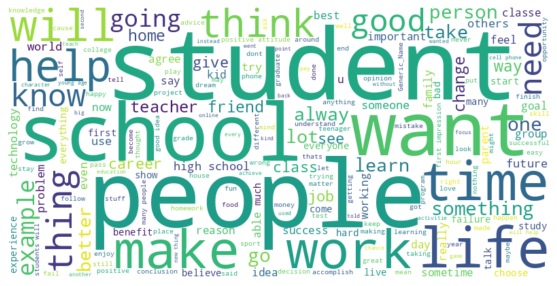

In [15]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(train.full_text))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Histogram of the distribution of the total number of words** 

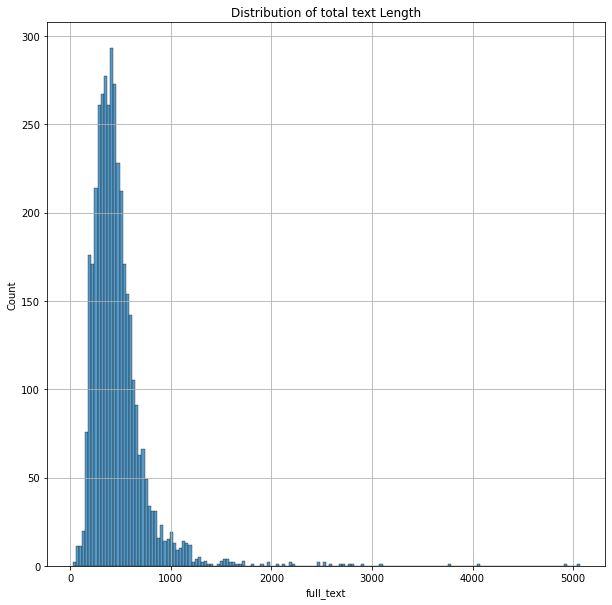

In [16]:
total_words=train.full_text.apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,10))
sns.histplot(total_words)
plt.grid()
plt.title("Distribution of total text Length");

# **Modelling**

### I have used TD-IDF for feature extration and Decision Tree for modelling

In [17]:
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

In [18]:
ATTRS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [19]:
x= train ['full_text'].values
y= train[ATTRS].values

In [20]:
x.shape

(3911,)

In [21]:
y.shape

(3911, 6)

In [25]:
#nltk
import nltk
nltk.download("stopwords")
stopwords_corpus=nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


It is seen that Decision tree mostly split on stop words. It's not reasonable to remove stop words because we are evaluating essays.

To resolve this, I would use 2 feature extractors:

* TD-IDF extractor with ngrame_range=(3,6),which can be helpful for grammar or cohesion classes

* TD-IDF extractor with stop words extraction,which helps introduce more information in the decision tree

In [26]:
vectorizer_ngram=TfidfVectorizer(ngram_range=(3,6),max_features=1000)
vectorizer_stop_words=TfidfVectorizer(stop_words=eng_stop_words,max_df=0.7,max_features=500)

feature_extractor = FeatureUnion([
    ('tfidf_ngram',vectorizer_ngram),
    ('tfidf_stop_words', vectorizer_stop_words)
    
])

x=feature_extractor.fit_transform(x)

print(x.shape)

(3911, 1500)


In [27]:
reg = tree.DecisionTreeRegressor()
reg = reg.fit(x,y)

In [28]:
x_test = test['full_text'].values

In [29]:
x_test = feature_extractor.transform(x_test)
print(x_test.shape)

(3, 1500)


In [30]:
y_test = reg.predict(x_test)
print(y_test.shape)

(3, 6)


In [31]:
test[ATTRS]=y_test
test.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,2.0,2.0,2.5,3.0,2.5,2.5
1,000BAD50D026,Do you think students would benefit from being...,2.0,2.5,3.0,2.5,2.0,2.0
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.5,3.5,3.0,3.5,3.0,3.5
